In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import networkx as nx
import random
import matplotlib.pyplot as plt
import sys
import os
import json
import numpy as np
import pandas as pd
import glob
import seaborn as sns

/var/folders/dc/ckm_vfws7gj46c116ltm28k00000gn/T/ipykernel_11433/3255959764.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Plot Results

In [66]:
def is_float(element) -> bool:
    try:
        float(element)
        return True
    except ValueError:
        return False
    
densities = []
relations = []
bonferronies = []
df = pd.DataFrame(columns=['node_number', 'density', 'weight_ratio', 'node_number_ratio', 'graph_type', 'power',
                           'probability_S_in_G1', 'p_value_G1', 'p_value_G2', 'optimal_bs_1', 'optimal_bs_1', 'p_bonferroni'])
bonf_files = glob.glob('configs56/*.json')
for ind, js_fn in enumerate(bonf_files):
    js = json.load(open(js_fn))
    df.loc[ind, :] = list(map(lambda x: float(x) if is_float(x) else x, js_fn.rstrip('.json').split(os.path.sep)[-1].split('_')[-5:])) + \
    [js['power'], js['probability_S_in_G1'], js['p_value_G1'], js['p_value_G2'], js['optimal_bs_1'], 
     js['optimal_bs_2'], js['p_bonferroni']]

df = df.sort_values(by=['node_number', 'density', 'weight_ratio', 'node_number_ratio', 'p_bonferroni'])
df.loc[:, 'node_number'] = df['node_number'].astype(int)
df.loc[:, 'significant'] = df['p_bonferroni'] < 0.05
df.loc[:, 's_nodes'] = df['node_number_ratio'] * df['node_number']
df

,node_number,density,weight_ratio,node_number_ratio,graph_type,power,probability_S_in_G1,p_value_G1,p_value_G2,optimal_bs_1,optimal_bs_1,p_bonferroni,significant,s_nodes
2,1000,0.1,1.0,0.005,path,49.828921,0.0,1,1,T,T,999999999999998.5,False,5.0
11,1000,0.1,1.0,0.005,clique,49.828921,0.0,1,1,T,T,999999999999998.5,False,5.0
12,1000,0.1,1.0,0.01,clique,99.657843,0.0,1,1,T,T,999999999999997064397369376768.0,False,10.0
15,1000,0.1,1.0,0.01,path,99.657843,0.0,1,1,T,T,999999999999997064397369376768.0,False,10.0
1,1000,0.1,1.1,0.005,clique,13.965784,0.000063,0.0,0.0,TTTTT,TTTTT,0.0,True,5.0
34,1000,0.1,1.1,0.005,path,13.965784,0.000063,0.0,0.0,TTTTT,TTTTT,0.0,True,5.0
10,1000,0.1,1.1,0.01,path,18.965784,0.000002,0.0,0.0,TTTTTTTTTT,TTTTTTTTTT,0.0,True,10.0
33,1000,0.1,1.1,0.01,clique,18.965784,0.000002,0.0,0.0,TTTTTTTTTT,TTTTTTTTTT,0.0,True,10.0
30,1000,0.1,1.2,0.005,clique,13.965784,0.000063,0.0,0.0,TTTTT,TTTTT,0.0,True,5.0
47,1000,0.1,1.2,0.005,path,13.965784,0.000063,0.0,0.0,TTTTT,TTTTT,0.0,True,5.0


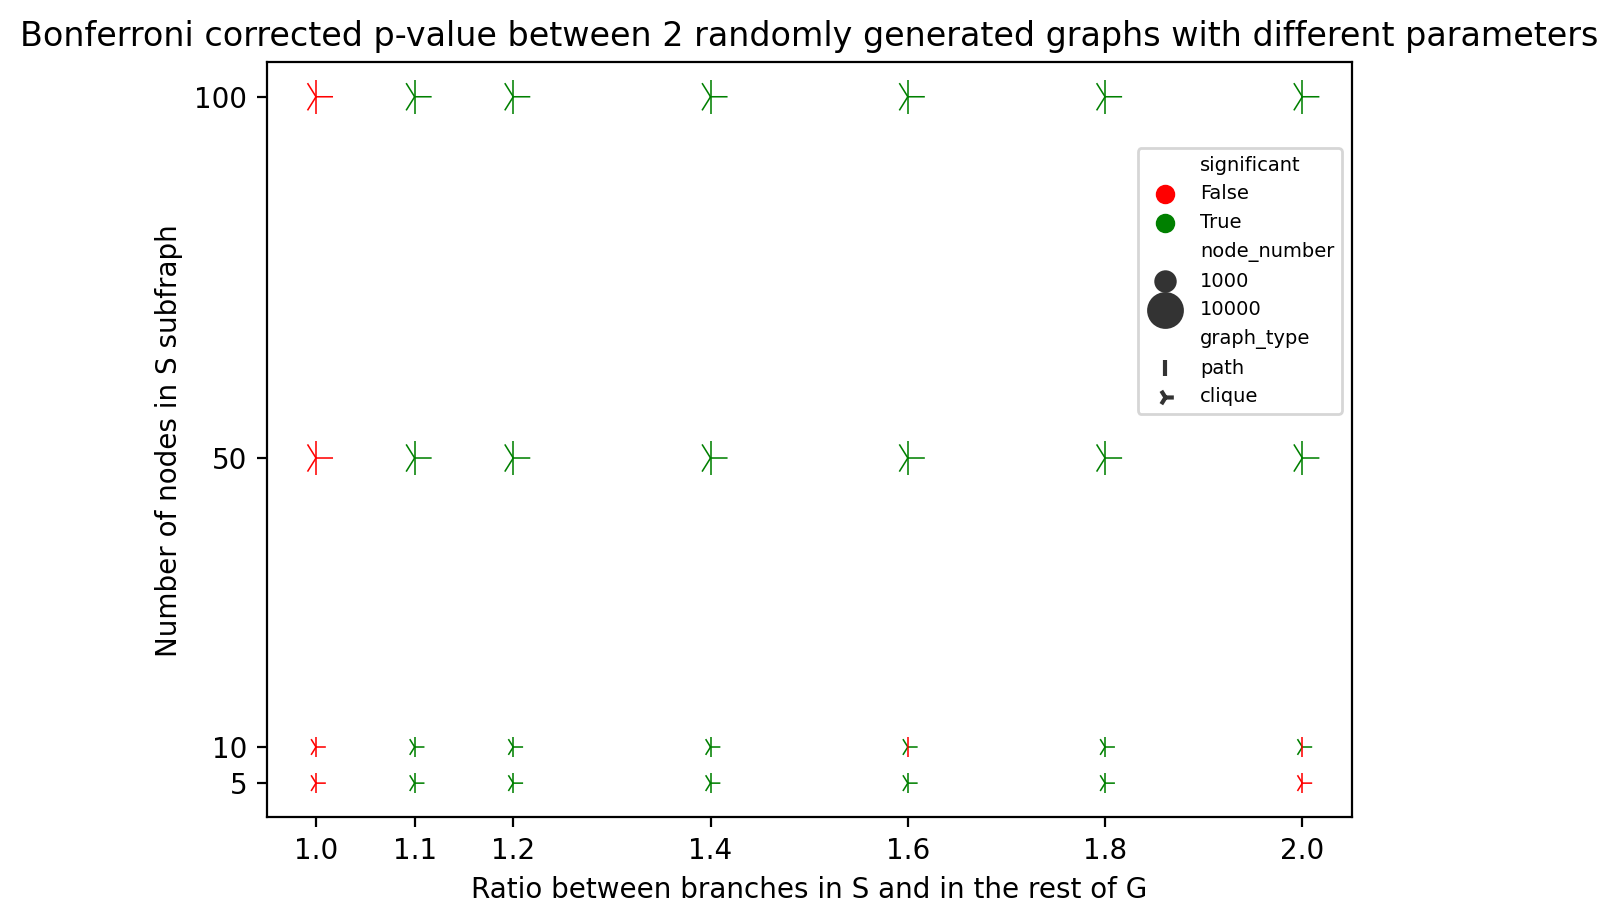

In [65]:
markers = {"path": '|', "clique": '4'}
plt.figure(figsize=(7,5), dpi=200)
sns.scatterplot(data=df, x='weight_ratio', y='s_nodes', size='node_number', hue='significant', palette=['r', 'g'], style='graph_type', markers=markers, sizes=(50,150))
plt.yticks([5, 10, 50, 100])
plt.xticks([1, 1.1, 1.2, 1.4, 1.6, 1.8, 2])
plt.legend(fontsize=7, bbox_to_anchor=(0.5, 0., 0.5, 0.9)) # using a size in points
plt.title('Bonferroni corrected p-value between 2 randomly generated graphs with different parameters')
plt.xlabel('Ratio between branches in S and in the rest of G')
plt.ylabel('Number of nodes in S subfraph')
plt.savefig('bonferroni.png', bbox_inches='tight')

# Draw graph

G:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
G:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


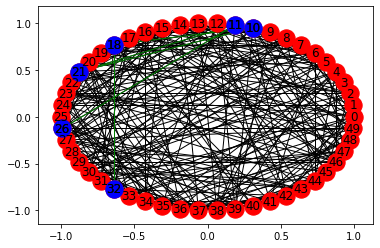

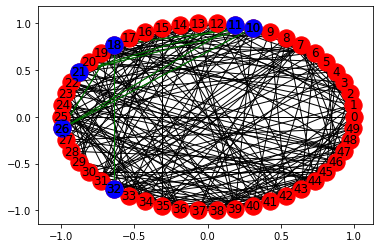

In [65]:
edge_weights = nx.get_edge_attributes(G1,'weight')

pos=nx.circular_layout(G1)
nx.draw_networkx(G1, pos=pos)
nx.draw_networkx(nx.induced_subgraph(G1, S), pos=pos, node_color = 'blue', edge_color = 'green')
#nx.draw_networkx_edge_labels(G1, pos, edge_labels = edge_weights)
plt.show()

pos=nx.circular_layout(G2)
nx.draw_networkx(G2, pos=pos)
nx.draw_networkx(nx.induced_subgraph(G2, S), pos=pos, node_color = 'blue', edge_color = 'green')
#nx.draw_networkx_edge_labels(G2, pos, edge_labels = edge_weights)
plt.show()

In [12]:
pruned = pd.read_csv('/Users/vladimirk/Documents/work/CTD/data/graphcarbostromal_5000pruned02_fixed.csv')

In [13]:
pruned

,Gzmf,H2.Q7,Oxtr,Rsc1a1,Pnpla3,Pira1,Chil1,Dsp,Myl1,Prss35,...,Homez,Poc5,Timm17b,Slc12a2,Zkscan5,Cwf19l1,Crlf2,Ccl9,Mlycd,Plscr2
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.201622,0.382835,0.0,0.0,0.226626,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
4996,0.0,0.0,0.226626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.245737,0.0,0.0,0.000000,0.0,0.434716,0.0
4997,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
4998,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.269845,0.000000,0.0,0.0,0.434716,0.0,0.000000,0.0
